# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

The goal of this modeling is to predict if a person has one or more of any of three medical conditions or none.

Rough breakdown of notebook contents:

1. Import libraries
2. Load Data
3. Data cleaning and preprocessing
4. Modeling

### Summary of Modeling Choices

<table>
  <tr>
    <th style="text-align:left;">Choice</th>
    <th style="text-align:left;">Details</th>
  </tr>
  <tr>
    <td style="text-align:left;">Data Preprocessing</td>
    <td style="text-align:left;">training only (no greeks)</td>
  </tr>
  <tr>
    <td style="text-align:left;">Split</td>
    <td style="text-align:left;">random 80-20 (no time dependency)</td>
  </tr>
  <tr>
    <td style="text-align:left;">Class Imbalance Mitigation</td>
    <td style="text-align:left;">downsampling</td>
  </tr>
  <tr>
    <td style="text-align:left;">Feature Normalization</td>
    <td style="text-align:left;">Standard Scalar</td>
  </tr>
  <tr>
    <td style="text-align:left;">Metric</td>
    <td style="text-align:left;">ROC-AUC</td>
  </tr>
  <tr>
    <td style="text-align:left;">Loss</td>
    <td style="text-align:left;">Binary Crossentropy + Log Loss on Test</td>
  </tr>
</table>

#### Kaggle Competition Performance Metric:

$$\log \text { Loss }=\frac{-\frac{1}{N_0} \sum_{i=1}^{N_0} y_{0 i} \log p_{0 i}-\frac{1}{N_1} \sum_{i=1}^{N_1} y_{1 i} \log p_{1 i}}{2}$$

# 1. Import Libraries

In [77]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from keras import metrics
from tensorflow import keras

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

#improve figure resolution
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all rows

In [78]:
print("TensorFlow v" + tf.__version__)

TensorFlow v2.12.0


# 2. Load Data

In [79]:
data = pd.read_csv('../icr-identify-age-related-conditions/train.csv')
print("Full train dataset shape is {}".format(data.shape))

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [80]:
data.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# 3. Data Preprocessing

### Transform and Split Data

In [81]:
#convert ej column to one-hot encoding 

ej_dummy = pd.get_dummies(
    data['EJ'],prefix='EJ', dtype=int
)

with_dummies_df = pd.concat(
    [data,ej_dummy],
    axis=1
)

data = with_dummies_df.drop(['EJ'], axis=1)
data.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'EJ_A',
       'EJ_B'],
      dtype='object')

In [82]:
#split data into test /train on a random 80-20 split
train, test = train_test_split(data, test_size=0.2, random_state = 1234)

#split train data into train/validatoin on a random 80-20 split
train, val = train_test_split(train, test_size=0.2, random_state = 1234)

In [83]:
len(train)

394

## Training + Validation Preprocessing

### Dealing with Class Imbalance

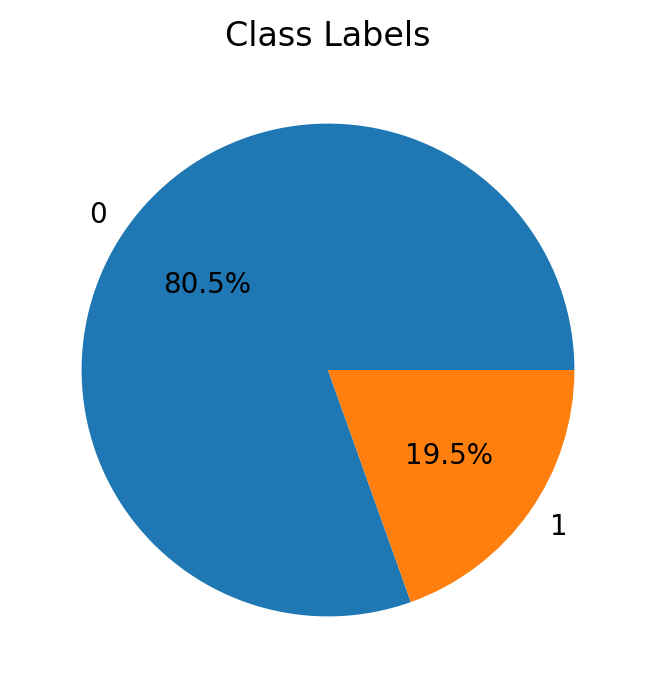

In [84]:
dist = train['Class'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist, labels=[0,1], autopct='%1.1f%%')
plt.title('Class Labels')
plt.show()

#### Downsample Training Only

*Removed step in favor of using class weights*

In [85]:
# # Separate majority and minority classes
# majority_class = train[train['Class'] == 0]
# minority_class = train[train['Class'] == 1]

# # Downsample the majority class to match the size of the minority class
# downsampled_majority = resample(majority_class,
#                                 replace=False,     # Without replacement
#                                 n_samples=len(minority_class),  # Match minority class size
#                                 random_state=42)   # For reproducibility

# # Combine the downsampled majority class with the minority class
# train = pd.concat([downsampled_majority, minority_class])

# # Shuffle the data to avoid any order bias
# train = train.sample(frac=1, random_state=42)

### Missing Data

In [86]:
train_summary = train.describe().transpose()
train_summary.head()

,count,mean,std,min,25%,50%,75%,max
AB,394.0,0.485945,0.500893,0.081187,0.252107,0.346113,0.567241,6.161666
AF,394.0,3521.997301,2336.967612,192.593280,2217.975375,3241.467790,4383.745905,28688.187660
AH,394.0,120.359750,130.325512,85.200147,85.200147,85.200147,112.472380,1910.123198
AM,394.0,41.411343,77.617727,4.617627,12.423616,21.135476,38.160847,630.518230
AR,394.0,9.980743,9.328152,8.138688,8.138688,8.138688,8.138688,173.534448


We have multiple columns with missing data, as can be seen below. The columns with the most missing data are BQ and EL, each with 60 null values. Since 60 null values amounts to only about 10% of the dataset, it is reasonable to use imputation to fill the missing values.

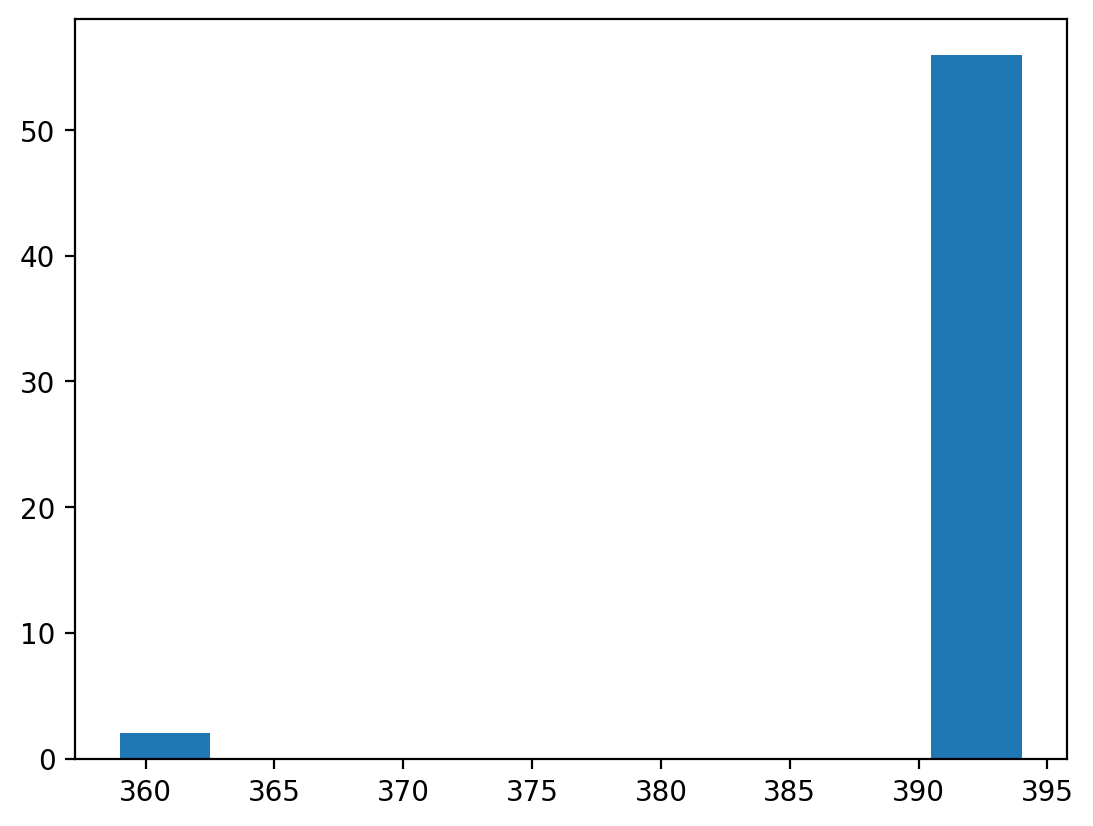

Summary of Columns with Missing Data:


,count,mean,std,min,25%,50%,75%,max
BQ,359.0,100.968701,95.248549,1.331155,29.006675,69.024685,136.680442,344.644105
CB,393.0,75.898050,129.061296,12.499760,22.223838,41.791477,76.901097,1467.150139
CC,392.0,0.697485,0.296833,0.176874,0.562474,0.667501,0.779250,4.103032
DU,393.0,1.859368,8.888265,0.005518,0.005518,0.255189,1.006962,161.355315
EL,359.0,70.325690,38.368006,5.394675,31.229270,71.949306,109.125159,109.125159
FC,393.0,70.495920,182.926302,7.728336,25.841088,35.694288,53.144448,3030.655824
FL,393.0,5.371248,11.125702,0.173229,0.173229,3.019391,6.122162,137.932739
FS,393.0,0.444295,1.607543,0.067730,0.067730,0.257374,0.528294,31.365763
GL,393.0,8.381793,10.317849,0.001129,0.126590,0.311607,21.978000,21.978000


In [87]:
plt.hist(train_summary['count'])
plt.show()
print("Summary of Columns with Missing Data:")
train_summary.loc[train_summary['count'] < 394]

Start with simple imputation which will fill missing values with the mean of the other values recorded for that feature. Note that iterative imputation is also possible through sk learn: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

In [88]:
# Identify continuous variables (assuming they are numeric)
continuous_vars = train.select_dtypes(include='number').columns

# Perform mean imputation for continuous variables
train[continuous_vars] = train[continuous_vars].fillna(train[continuous_vars].mean())

#Same for Validation
# Identify continuous variables (assuming they are numeric)
continuous_vars = val.select_dtypes(include='number').columns

# Perform mean imputation for continuous variables
val[continuous_vars] = val[continuous_vars].fillna(val[continuous_vars].mean())

In [89]:
# Check which columns still have missing values 
sum_null = train.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

### Split Training Set into X and Y

In [90]:
columns = train.columns.drop(['Id','Class'])
columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ_A', 'EJ_B'],
      dtype='object')

In [91]:
# save x_train, y_train, X_val and Y_val as Numpy arrays
y_train = train['Class'].values
y_val = val['Class'].values

X_train = train[columns].values
X_val = val[columns].values


# Check the shape of the train and val sets
print('Shape X_train: ', X_train.shape, '\nShape X_val: ', X_val.shape,
      '\nShape y_train: ', y_train.shape, '\nShape y_val:', y_val.shape)
    

Shape X_train:  (394, 57) 
Shape X_val:  (99, 57) 
Shape y_train:  (394,) 
Shape y_val: (99,)


### Standardize values between 0 and 1

In [92]:
#normalize all values to be between 0 and 1
# X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))

# #view normalized array
# print(X_train)

### Standard Scalar

In [93]:
# standardize features
sc = StandardScaler()

X_train = sc.fit(X_train).transform(X_train)
X_val = sc.fit(X_val).transform(X_val)

# 4. Model

Based on Juliana's analysis using Random Forest, we will start by focusing on the following features, in order of importance: 

**Suggested features for input:** DU, AB, BQ, GL, CR, DA, DI, AF, CC, EE, FR, DE, EB, DL, CD, FE, DH, BC, FI, EU, BN, BP, CU, CB, DY, FC, DN, AM, EG, CS, GH, CF, GF, BD, GI


#### Model with Specified Input Features

An alternative, more flexible option is to use logistic regression, creating an architecutre with a single dense layer and a sigmoid activation function. Logistic regression is very similar to a perceptron but allows us to predict probabilities of binary outcomes as opposed to just a -1 / 1 outcome.

In [94]:
#create a new array with selected features
feature_list = ['DU', 'AB','BQ','GL','CR','DA','DI','AF','CC','EE','FR',
                'DE','EB','DL','CD ','FE','DH','BC','FI','EU','BN', 'BP',
                'CU', 'CB', 'DY', 'FC', 'DN', 'AM','EG','CS','GH','CF','GF',
                'BD ','GI']
columns = list(columns)
X_limited_train = np.array([])
X_limited_val = np.array([])

for feature in feature_list:
    feature_index = columns.index(feature)
    feature_array_train = X_train[:, feature_index]
    feature_array_val = X_val[:, feature_index]
    
    if X_limited_train.size == 0:
        X_limited_train = feature_array_train
    else:
        X_limited_train = np.column_stack((X_limited_train, feature_array_train))
    
    if X_limited_val.size == 0:
        X_limited_val = feature_array_val
    else:
        X_limited_val = np.column_stack((X_limited_val, feature_array_val))

In [95]:
def perceptron_tfmodel(num_features, 
                       activation = 'sigmoid', 
                       learning_rate = 0.001, 
                       optimizer = 'SGD'
                       ):
    
    #clear session and set random seed for consistent behavior
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    #Build model using Keras Sequential API
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation = activation, input_shape = (num_features,))
    ])
    
    #set up optimizer
    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    if optimizer == 'Adam':
        optimizer = adam_optimizer
    else:
        optimizer = sgd_optimizer
    
    #compile model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
                  metrics=['accuracy', tf.keras.metrics.AUC(name='prc', curve='PR')])
    
    return model

In [96]:
model = perceptron_tfmodel(num_features = X_limited_train.shape[1], learning_rate = 0.1, optimizer = 'SDG')

In [97]:
#Fit the model
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_limited_train,
                y=y_train,
                validation_split=0.2, 
                #validation_data=(X_limited_val, y_val), 
                batch_size= 20, #choose smaller batch size bc we're guessing there are local optima 
                epochs=50,
                verbose=1, #silence fit
                class_weight = {0: 1.0, 1: 5.0}
)

Epoch 1/50
 1/16 [>.............................] - ETA: 4s - loss: 1.2030 - accuracy: 0.6500 - prc: 0.4606

2023-08-10 13:34:45.562986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 33ms/step - loss: 0.9618 - accuracy: 0.7206 - prc: 0.6172 - val_loss: 0.5440 - val_accuracy: 0.6835 - val_prc: 0.6677
Epoch 2/50
 1/16 [>.............................] - ETA: 0s - loss: 0.3926 - accuracy: 0.9500 - prc: 1.0000

2023-08-10 13:34:46.027568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 14ms/step - loss: 0.6994 - accuracy: 0.8222 - prc: 0.7878 - val_loss: 0.4641 - val_accuracy: 0.7595 - val_prc: 0.7243
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.6203 - accuracy: 0.8508 - prc: 0.8384 - val_loss: 0.4239 - val_accuracy: 0.8354 - val_prc: 0.7677
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.5732 - accuracy: 0.8508 - prc: 0.8550 - val_loss: 0.4019 - val_accuracy: 0.8354 - val_prc: 0.7683
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.5411 - accuracy: 0.8698 - prc: 0.8633 - val_loss: 0.3888 - val_accuracy: 0.8481 - val_prc: 0.7812
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 0.5184 - accuracy: 0.8889 - prc: 0.8700 - val_loss: 0.3751 - val_accuracy: 0.8354 - val_prc: 0.7777
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 0.5013 - accuracy: 0.8857 - prc: 0.8767 - val_loss: 0.3686 - val_accuracy

16/16 [==============================] - 0s 12ms/step - loss: 0.3750 - accuracy: 0.9270 - prc: 0.9079 - val_loss: 0.3228 - val_accuracy: 0.8861 - val_prc: 0.7453
Epoch 50/50
16/16 [==============================] - 0s 12ms/step - loss: 0.3732 - accuracy: 0.9302 - prc: 0.9100 - val_loss: 0.3239 - val_accuracy: 0.8861 - val_prc: 0.7453


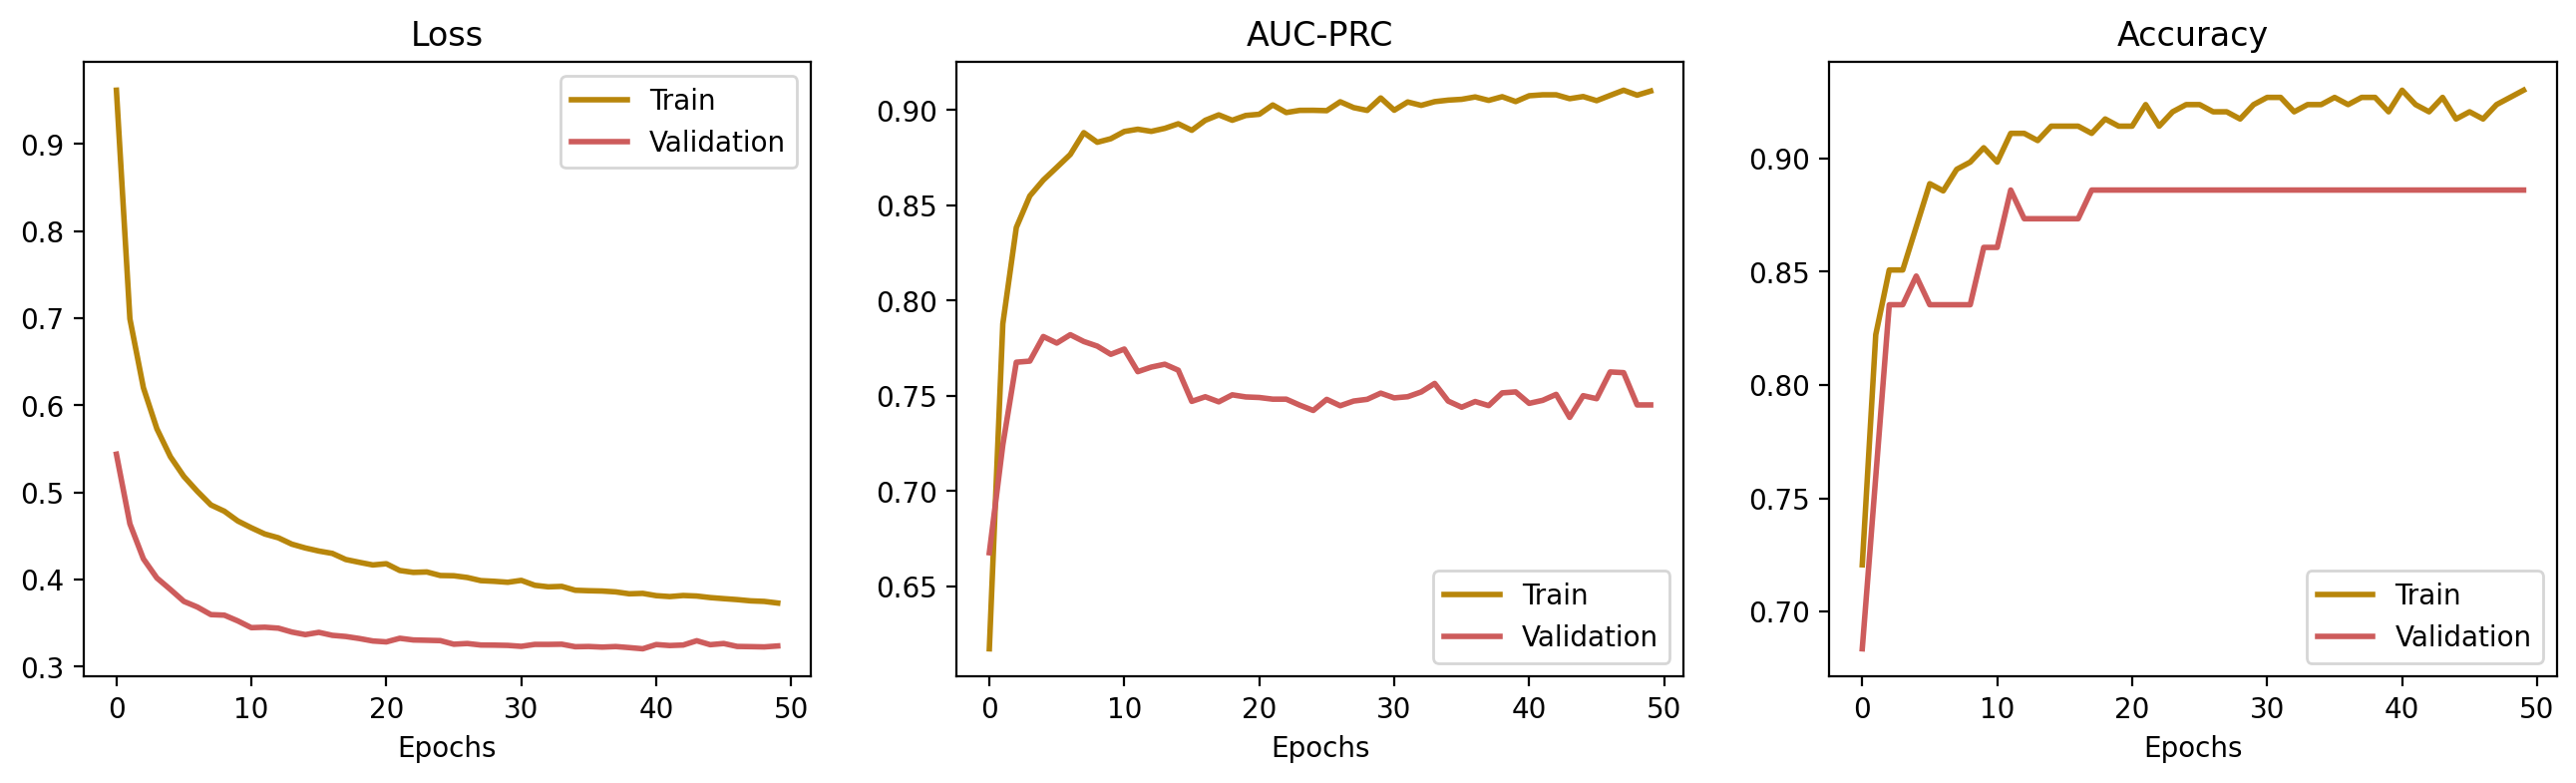


Baseline:          0.8046
Train Accuracy:     0.9302
AUC-PRC:           0.9100


In [98]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['prc'], lw=2, color='darkgoldenrod')
plt.plot(history['val_prc'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC-PRC');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 3)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

plt.show()

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_train == 0)/len(y_train)))
print('Train Accuracy:     %1.4f' %(history['accuracy'][-1]))
print('AUC-PRC:           %1.4f' %(history['prc'][-1]))

#### Model with all input features

In [99]:
model = perceptron_tfmodel(num_features = X_train.shape[1], learning_rate = 0.01, optimizer = 'Adam')

In [100]:
#Fit the model
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train,
                y=y_train,
                validation_split = 0.2,
                #validation_data=(X_val, y_val), # set 20% of train data for validation
                batch_size= 20, #choose smaller batch size bc we're guessing there are local optima 
                epochs=50,
                verbose=1, #silence fit
                class_weight = {0: 1.0, 1: 5.0}
)

Epoch 1/50


2023-08-10 13:34:56.581341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 35ms/step - loss: 1.5668 - accuracy: 0.4635 - prc: 0.2608 - val_loss: 0.6756 - val_accuracy: 0.6203 - val_prc: 0.5308
Epoch 2/50
 1/16 [>.............................] - ETA: 0s - loss: 1.0636 - accuracy: 0.6000 - prc: 0.2069

2023-08-10 13:34:57.144364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 17ms/step - loss: 1.0333 - accuracy: 0.6095 - prc: 0.5524 - val_loss: 0.5993 - val_accuracy: 0.7215 - val_prc: 0.6362
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.8304 - accuracy: 0.6857 - prc: 0.7244 - val_loss: 0.5567 - val_accuracy: 0.7722 - val_prc: 0.6851
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.7334 - accuracy: 0.7619 - prc: 0.7795 - val_loss: 0.5228 - val_accuracy: 0.7342 - val_prc: 0.7226
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6641 - accuracy: 0.8032 - prc: 0.8148 - val_loss: 0.4948 - val_accuracy: 0.7595 - val_prc: 0.7385
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 0.6135 - accuracy: 0.8444 - prc: 0.8387 - val_loss: 0.4727 - val_accuracy: 0.7595 - val_prc: 0.7593
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 0.5762 - accuracy: 0.8540 - prc: 0.8526 - val_loss: 0.4547 - val_accuracy

16/16 [==============================] - 0s 13ms/step - loss: 0.2815 - accuracy: 0.9365 - prc: 0.9394 - val_loss: 0.3492 - val_accuracy: 0.8354 - val_prc: 0.7249
Epoch 50/50
16/16 [==============================] - 0s 13ms/step - loss: 0.2806 - accuracy: 0.9333 - prc: 0.9371 - val_loss: 0.3459 - val_accuracy: 0.8354 - val_prc: 0.7250


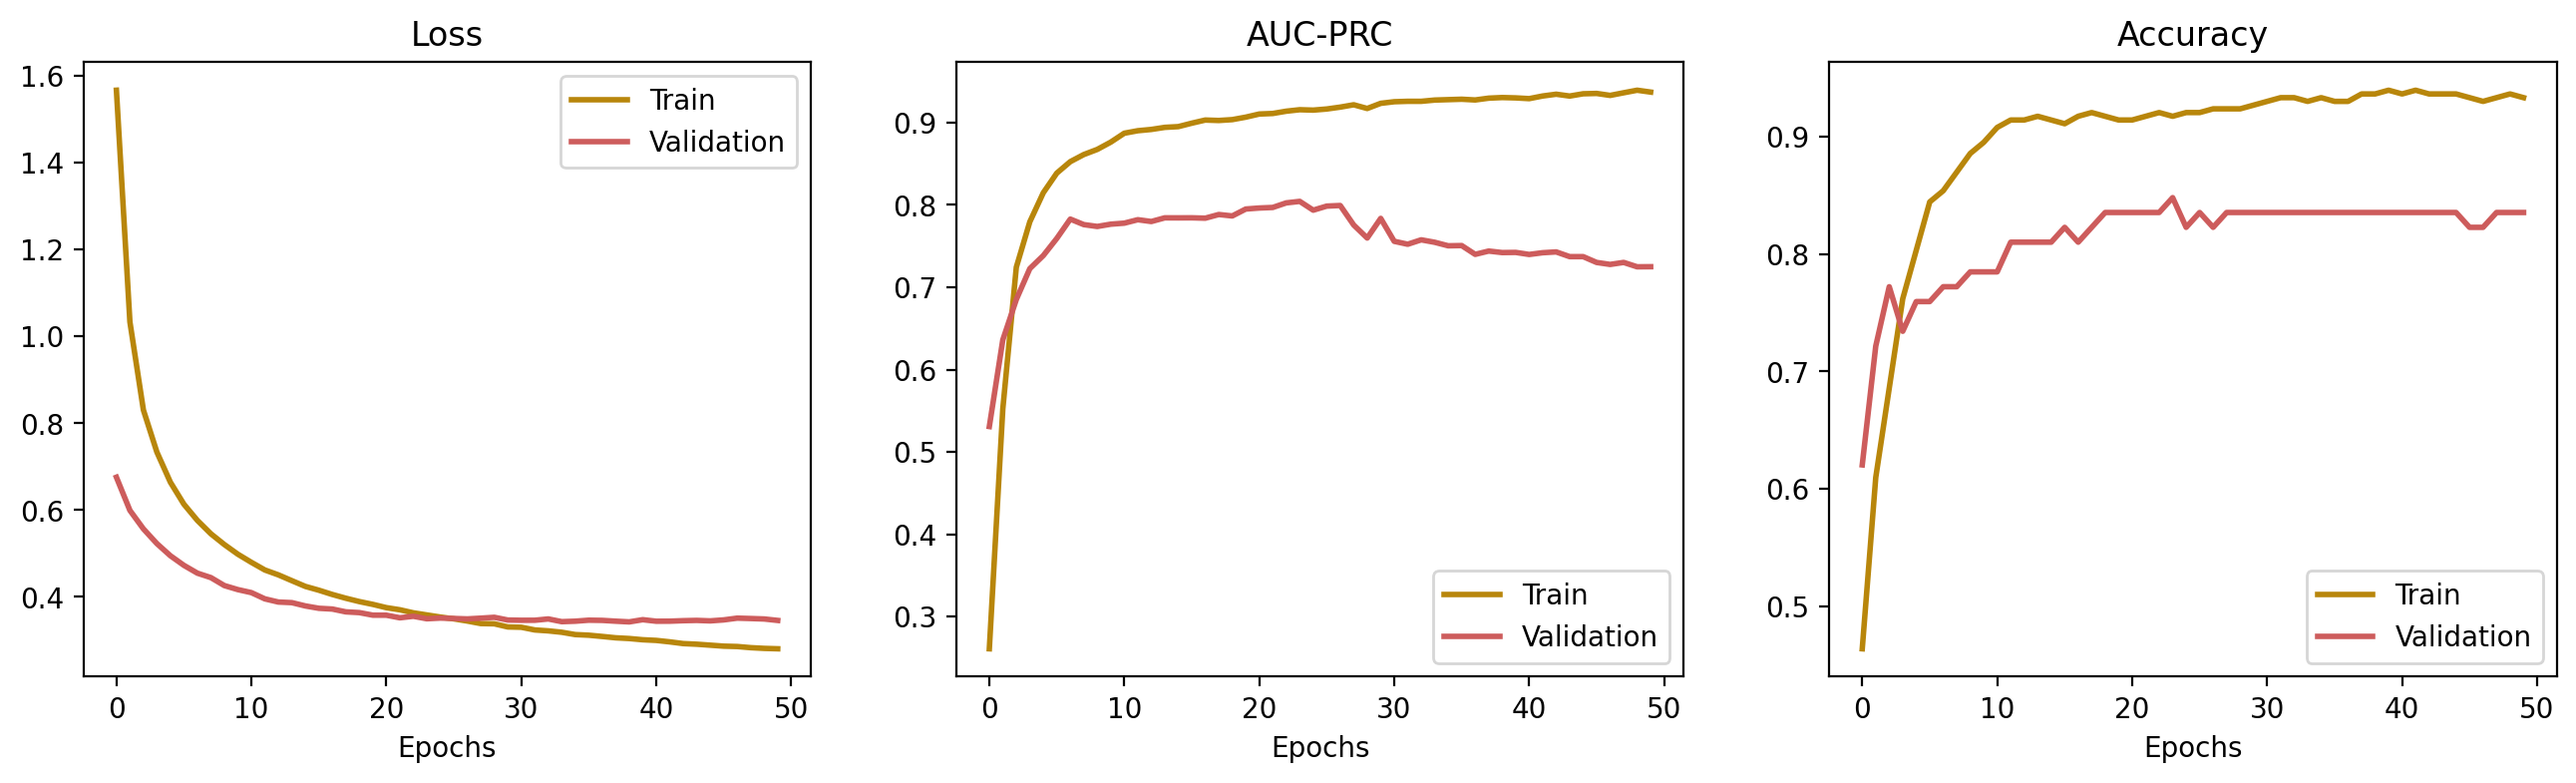


Baseline:          0.8046
Train Accuracy:     0.9333
AUC-PRC:           0.9371


In [101]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['prc'], lw=2, color='darkgoldenrod')
plt.plot(history['val_prc'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC-PRC');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 3)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

plt.show()

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_train == 0)/len(y_train)))
print('Train Accuracy:     %1.4f' %(history['accuracy'][-1]))
print('AUC-PRC:           %1.4f' %(history['prc'][-1]))

## Ablation Study: Logistic Regression

### First Study: Feature Set + Class Balancing

> - learning_rate = 0.1
> - optimizer = 'SDG'
> - batch size = 20
> - validation split = 0.2
> - class_weight = {0: 1.0, 1: 5.0}

<table>
  <tr>
    <th style="text-align:left;">Feature Set</th>
    <th style="text-align:left;">Class Mitigation Technique</th>
    <th style="text-align:left;">Validation Loss</th>
    <th style="text-align:left;">Validation Accuracy</th>
    <th style="text-align:left;">Validation AUC-PRC</th>
  </tr>
  <tr>
    <th style="text-align:left;">Top RF Features</th>
    <th style="text-align:left;">Class Weights</th>
    <th style="text-align:left;">0.4640</th>
    <th style="text-align:left;">0.7879</th>
    <th style="text-align:left;">0.6998</th>
  </tr>  
  <tr>
    <th style="text-align:left;">Top RF Features</th>
    <th style="text-align:left;">Downsampling</th>
    <th style="text-align:left;">1.5129</th>
    <th style="text-align:left;">0.6935</th>
    <th style="text-align:left;">0.5837</th>
  </tr>
  <tr>
    <th style="text-align:left;">Full Training Set</th>
    <th style="text-align:left;">Class Weights</th>
    <th style="text-align:left;">0.4494</th>
    <th style="text-align:left;">0.8182</th>
    <th style="text-align:left;">0.7466</th>
  </tr>
  <tr>
    <th style="text-align:left;">Full Training Set</th>
    <th style="text-align:left;">Downsampling</th>
    <th style="text-align:left;">1.3208</th>
    <th style="text-align:left;">0.6452</th>
    <th style="text-align:left;">0.5695</th>
  </tr>
</table>



### Second Study: Hyperparameter Tuning

> - Feature set = Full Training
> - Class Balancing: class_weight = {0: 1.0, 1: 5.0}
> - validation split = 0.2
> - learning_rate = [0.5, 0.1, 0.01]
> - optimizer = ['SDG', 'Adam]
> - batch size = [20, 30]


<table>
  <tr>
    <th style="text-align:left;">Learning Rate</th>
    <th style="text-align:left;">Optimizer</th>
    <th style="text-align:left;">Batch Size</th>
    <th style="text-align:left;">Validation Loss</th>
    <th style="text-align:left;">Validation Accuracy</th>
    <th style="text-align:left;">Validation AUC-PRC</th>
  </tr>
  <tr>
    <th style="text-align:left;">0.5</th>
    <th style="text-align:left;">SGD</th>
    <th style="text-align:left;">20</th>
    <th style="text-align:left;">0.6281</th>
    <th style="text-align:left;">0.8081</th>
    <th style="text-align:left;">0.7031</th>
  </tr>  
  <tr>
    <th style="text-align:left;">0.1</th>
    <th style="text-align:left;">SGD</th>
    <th style="text-align:left;">20</th>
    <th style="text-align:left;">0.4562</th>
    <th style="text-align:left;">0.8182</th>
    <th style="text-align:left;">0.7476</th>
  </tr>  
  <tr>
    <th style="text-align:left;">0.01</th>
    <th style="text-align:left;">SDG</th>
    <th style="text-align:left;">20</th>
    <th style="text-align:left;">0.4460</th>
    <th style="text-align:left;">0.7980</th>
    <th style="text-align:left;">0.7744</th>
  </tr> 
    <tr>
    <th style="text-align:left;">0.5</th>
    <th style="text-align:left;">Adam</th>
    <th style="text-align:left;">20</th>
    <th style="text-align:left;">2.0861</th>
    <th style="text-align:left;">0.7980</th>
    <th style="text-align:left;">0.4358</th>
  </tr>  
  <tr>
    <th style="text-align:left;">0.1</th>
    <th style="text-align:left;">Adam</th>
    <th style="text-align:left;">20</th>
    <th style="text-align:left;">0.6860</th>
    <th style="text-align:left;">0.7980</th>
    <th style="text-align:left;">0.6070</th>
  </tr>  
  <tr>
    <th style="text-align:left;">0.01</th>
    <th style="text-align:left;">Adam</th>
    <th style="text-align:left;">20</th>
    <th style="text-align:left;">0.4290</th>
    <th style="text-align:left;">0.8384</th>
    <th style="text-align:left;">0.7942</th>
  </tr> 
    <tr>
    <th style="text-align:left;">0.01</th>
    <th style="text-align:left;">SDG</th>
    <th style="text-align:left;">30</th>
    <th style="text-align:left;">0.4483</th>
    <th style="text-align:left;">0.8384</th>
    <th style="text-align:left;">0.7444</th>
  </tr>  
  <tr>
    <th style="text-align:left;">0.01</th>
    <th style="text-align:left;">Adam</th>
    <th style="text-align:left;">30</th>
    <th style="text-align:left;">0.4641</th>
    <th style="text-align:left;">0.8384</th>
    <th style="text-align:left;">0.7456</th>
  </tr> 
  <tr>
    <th style="text-align:left;">0.01</th>
    <th style="text-align:left;">Adam</th>
    <th style="text-align:left;">15</th>
    <th style="text-align:left;">0.4150</th>
    <th style="text-align:left;">0.8283</th>
    <th style="text-align:left;">0.7978</th>
  </tr> 
  <tr>
    <th style="text-align:left;">0.001</th>
    <th style="text-align:left;">Adam</th>
    <th style="text-align:left;">20</th>
    <th style="text-align:left;">0.5207</th>
    <th style="text-align:left;">0.7576</th>
    <th style="text-align:left;">0.7419</th>
  </tr> 
</table>



**Conclusion:** The full number of features with a balancint technique of class weights provides better performance. We chose to go with the hyperparameters [0.01, Adam, 20].

# Test

### Test Preprocessing

In [102]:
def balanced_log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0) #num observations class 0
    N1 = np.sum(y_true == 1) #num observations class 1

    p0 = y_pred[y_true == 0] #pred_prob class 0
    p1 = y_pred[y_true == 1] #pred_prob class 0

    y0 = y_true[y_true == 0] #ground truth class 0
    y1 = y_true[y_true == 1] #ground truth class 1

    log_loss_0 = np.sum(y0 * np.log(np.clip(p0, 1e-15, 1.0))) / N0 if N0 > 0 else 0 #balanced log loss class 0, adjust for edge cases (removed the negative sign to avoid negative log loss)
    log_loss_1 = np.sum(y1 * np.log(np.clip(p1, 1e-15, 1.0))) / N1 if N1 > 0 else 0 #balanced log loss class 1, adjust for edge cases 

    return (log_loss_0 + log_loss_1) / 2

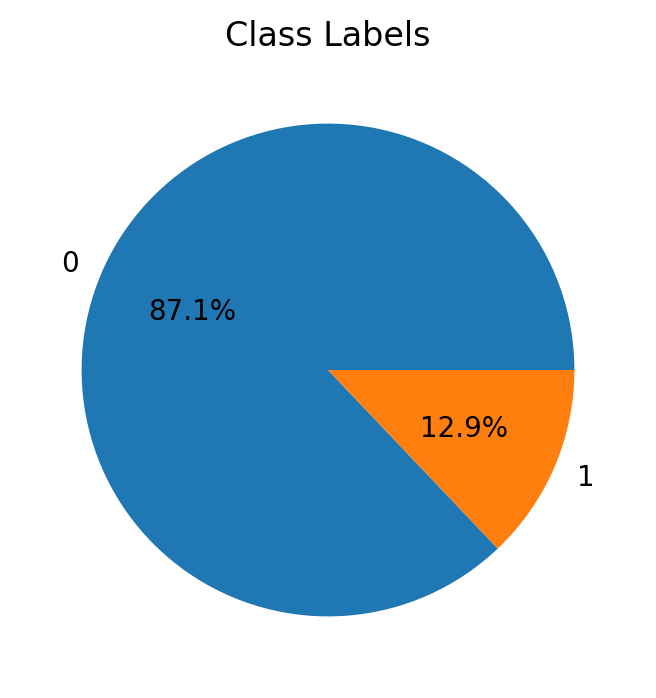

In [103]:
dist = test['Class'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist, labels=[0,1], autopct='%1.1f%%')
plt.title('Class Labels')
plt.show()

In [104]:
# Identify continuous variables (assuming they are numeric)
continuous_vars = test.select_dtypes(include='number').columns

# Perform mean imputation for continuous variables
test[continuous_vars] = test[continuous_vars].fillna(test[continuous_vars].mean())

In [105]:
# save X_test and Y_test as Numpy arrays

y_test = test['Class'].values
X_test = test[columns].values

# Check the shape of the test sets
    
print('Shape X_test: ', X_test.shape,
      '\nShape y_test: ', y_test.shape)

Shape X_test:  (124, 57) 
Shape y_test:  (124,)


In [106]:
# standardize features
sc = StandardScaler()

X_test = sc.fit(X_test).transform(X_test)

In [107]:
#limit the features

X_limited_test = np.array([])

for feature in feature_list:
    feature_index = columns.index(feature)
    feature_array = X_test[:, feature_index]
    
    if X_limited_test.size == 0:
        X_limited_test = feature_array
    else:
        X_limited_test = np.column_stack((X_limited_test, feature_array))

### Retrain the Chosen Model

In [108]:
model = perceptron_tfmodel(num_features = X_train.shape[1], learning_rate = 0.01, optimizer = 'Adam')

In [109]:
#Fit the model
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train,
                y=y_train,
                validation_split=0.2, # set 20% of train data for validation
                batch_size= 20, #choose smaller batch size bc we're guessing there are local optima 
                epochs=50, 
                verbose=1, #silence fit
                class_weight = {0: 1.0, 1: 5.0}
)

Epoch 1/50


2023-08-10 13:35:08.501687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 33ms/step - loss: 1.4455 - accuracy: 0.5175 - prc: 0.2745 - val_loss: 0.6315 - val_accuracy: 0.6329 - val_prc: 0.5677
Epoch 2/50
 1/16 [>.............................] - ETA: 0s - loss: 1.1922 - accuracy: 0.4500 - prc: 0.4381

2023-08-10 13:35:09.049911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 16ms/step - loss: 0.9960 - accuracy: 0.6381 - prc: 0.5217 - val_loss: 0.5727 - val_accuracy: 0.6456 - val_prc: 0.6414
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.8026 - accuracy: 0.7048 - prc: 0.7281 - val_loss: 0.5344 - val_accuracy: 0.6582 - val_prc: 0.6879
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.7136 - accuracy: 0.7397 - prc: 0.8089 - val_loss: 0.5030 - val_accuracy: 0.7215 - val_prc: 0.7155
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.6518 - accuracy: 0.7841 - prc: 0.8402 - val_loss: 0.4736 - val_accuracy: 0.7342 - val_prc: 0.7376
Epoch 6/50
16/16 [==============================] - 0s 15ms/step - loss: 0.6086 - accuracy: 0.8190 - prc: 0.8621 - val_loss: 0.4503 - val_accuracy: 0.7595 - val_prc: 0.7467
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 0.5739 - accuracy: 0.8413 - prc: 0.8736 - val_loss: 0.4340 - val_accuracy

16/16 [==============================] - 0s 13ms/step - loss: 0.2838 - accuracy: 0.9365 - prc: 0.9401 - val_loss: 0.3162 - val_accuracy: 0.8987 - val_prc: 0.7273
Epoch 50/50
16/16 [==============================] - 0s 14ms/step - loss: 0.2826 - accuracy: 0.9333 - prc: 0.9410 - val_loss: 0.3130 - val_accuracy: 0.8861 - val_prc: 0.7328


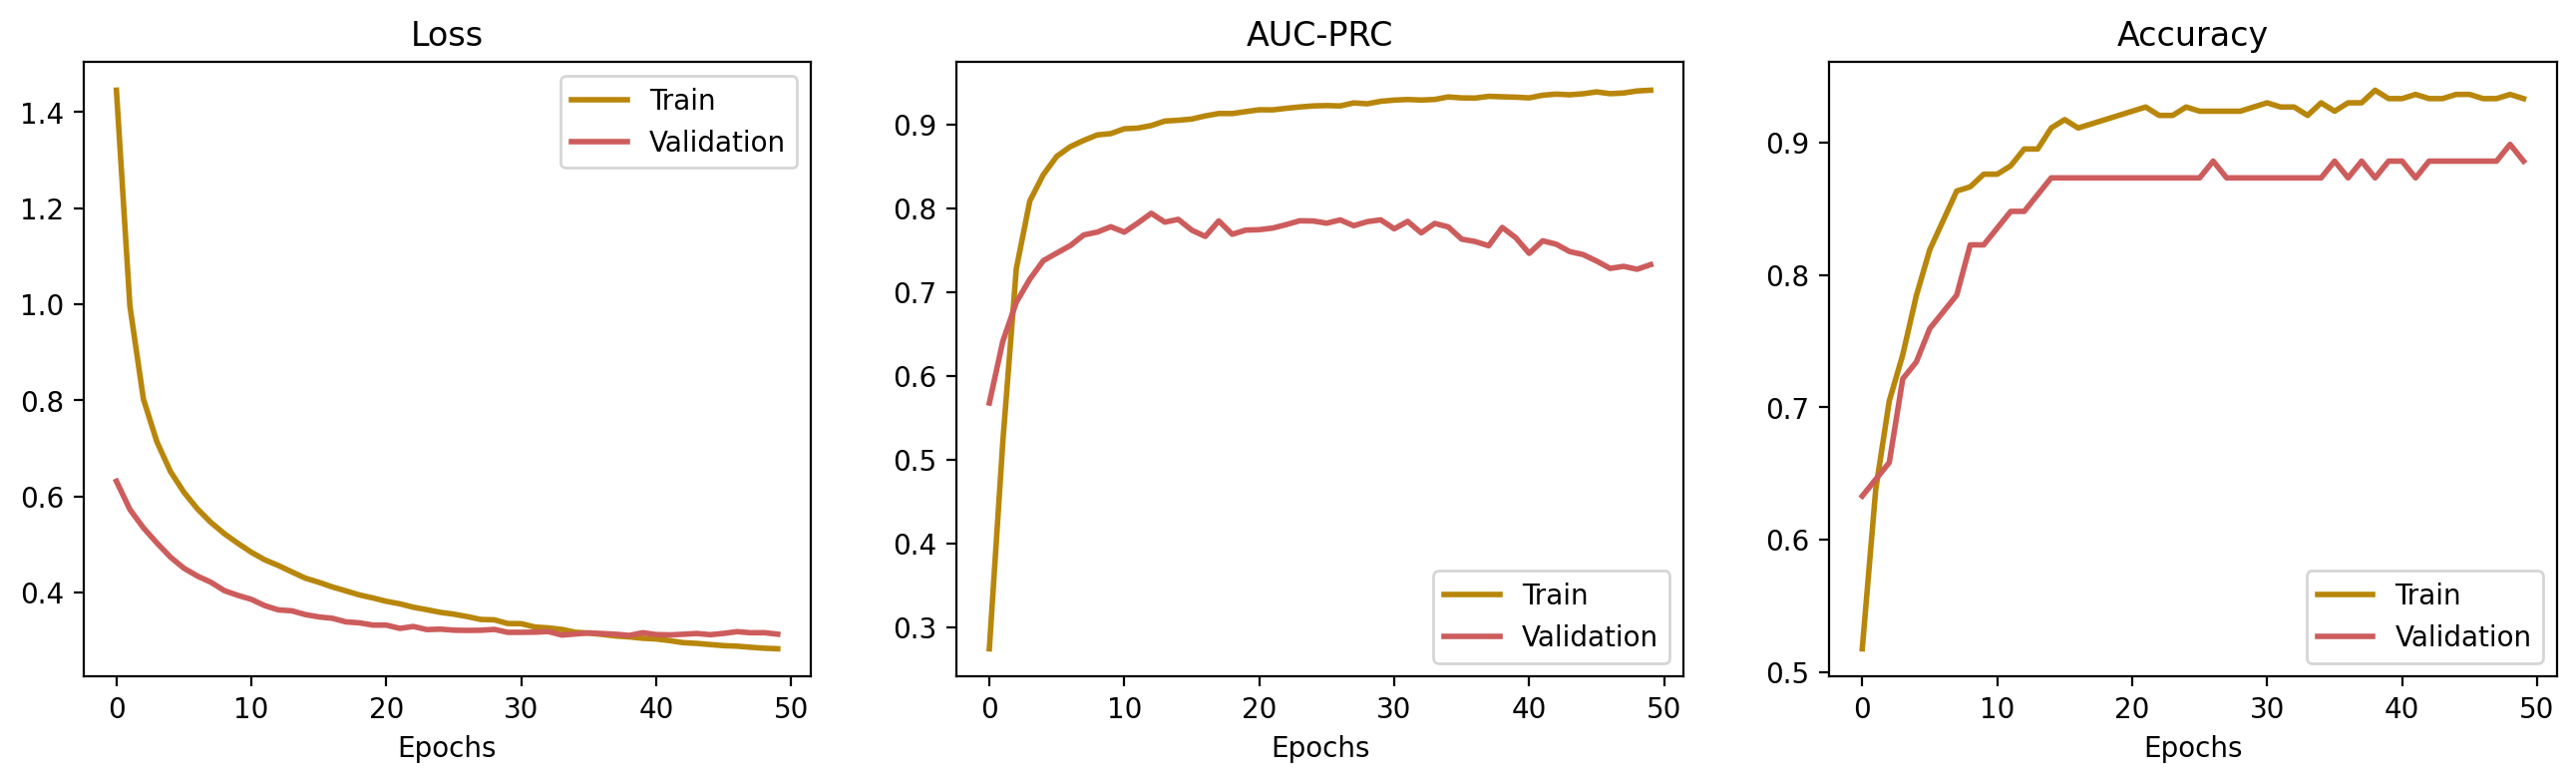


Baseline:          0.8046
Train Loss:           0.2826
Val Loss:           0.3130
Train Accuracy:     0.9333
Val Accuracy:     0.8861
AUC-PRC:           0.9410
Val AUC-PRC:           0.7328


In [110]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['prc'], lw=2, color='darkgoldenrod')
plt.plot(history['val_prc'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC-PRC');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 3)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

plt.show()

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_train == 0)/len(y_train)))
print('Train Loss:           %1.4f' %(history['loss'][-1]))
print('Val Loss:           %1.4f' %(history['val_loss'][-1]))
print('Train Accuracy:     %1.4f' %(history['accuracy'][-1]))
print('Val Accuracy:     %1.4f' %(history['val_accuracy'][-1]))
print('AUC-PRC:           %1.4f' %(history['prc'][-1]))
print('Val AUC-PRC:           %1.4f' %(history['val_prc'][-1]))

### Test the model

In [111]:
model_eval = model.evaluate(x=X_test, y=y_test,
                                verbose=0, return_dict=True)

y_test_pred = model.predict(x=X_test, verbose=0)

print('\nBaseline:          %1.4f' %(np.count_nonzero(y_test == 0)/len(y_test)))
print('Test Loss:     %1.4f' %(model_eval['loss']))
print('Test Accuracy:     %1.4f' %(model_eval['accuracy']))
print('Test AUC-PRC:           %1.4f' %(model_eval['prc']))
print('Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test, y_test_pred)))


Baseline:          0.8710
Test Loss:     1.3010
Test Accuracy:     0.8226
Test AUC-PRC:           0.4670
Balanced Log Loss: -1.1832


2023-08-10 13:35:20.476362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


**Conclusion:** The logistic regression model performs way better than a basic perceptron since a perceptron didn't converge at all. That said, the AUC-PRC score for the train/validation sets didn't exceed 0.8 which would be unsatisfactory for healthcare applications. The accuracy and AUC/PRC of the test set are lower than the validation set which suggests some data leakage or overfit occured in the modeling.